In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

1.0


In [4]:
# load data
path = 'training_data.csv'
# path = 'ThisYearBackupCapacity.csv'
df = pd.read_csv(path, header=0)
df['日期'] = pd.Series(df['日期'], dtype="string")
df['日期'] = pd.to_datetime(df['日期'], format='%Y-%m-%d')
# df['備轉容量(萬瓩)'] = df['備轉容量(萬瓩)'].apply(lambda x: 10*int(x))
print(df.shape)
df.tail()

(424, 71)


,日期,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),核一#1(萬瓩),核一#2(萬瓩),核二#1(萬瓩),...,大觀二,明潭,碧海,立霧,龍澗,卓蘭,水里,其他小水力,風力發電,太陽能發電
419,2022-02-24,33609,31098,2511,8.07,371.852,278.004,0,0,-0.1,...,30.5,52.0,5.8,0.2,6.5,8.1,0.0,20.9,66.8,0.2
420,2022-02-25,33527,30121,3406,11.31,365.893,273.548,0,0,-0.1,...,33.1,81.9,5.3,2.8,9.8,8.1,0.4,21.1,42.0,0.4
421,2022-02-26,31259,27822,3437,12.35,342.340,255.939,0,0,-0.1,...,31.4,66.4,5.3,2.8,7.0,8.1,0.7,20.7,11.2,0.5
422,2022-02-27,29926,26196,3730,14.24,317.200,237.145,0,0,-0.1,...,32.0,78.3,5.3,2.8,4.8,8.1,0.2,19.2,15.4,0.0
423,2022-02-28,31464,27337,4127,15.10,323.679,241.988,0,0,-0.1,...,30.0,63.8,5.5,2.8,5.5,8.1,0.2,19.6,0.4,2.2


In [5]:
# preprocessing
min_max_scaler = MinMaxScaler()
df['備轉容量(MW)'] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df['備轉容量(MW)'])))
# df['備轉容量(萬瓩)'] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df['備轉容量(萬瓩)'])))
df.tail()

,日期,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),核一#1(萬瓩),核一#2(萬瓩),核二#1(萬瓩),...,大觀二,明潭,碧海,立霧,龍澗,卓蘭,水里,其他小水力,風力發電,太陽能發電
419,2022-02-24,33609,31098,0.196200,8.07,371.852,278.004,0,0,-0.1,...,30.5,52.0,5.8,0.2,6.5,8.1,0.0,20.9,66.8,0.2
420,2022-02-25,33527,30121,0.359700,11.31,365.893,273.548,0,0,-0.1,...,33.1,81.9,5.3,2.8,9.8,8.1,0.4,21.1,42.0,0.4
421,2022-02-26,31259,27822,0.365364,12.35,342.340,255.939,0,0,-0.1,...,31.4,66.4,5.3,2.8,7.0,8.1,0.7,20.7,11.2,0.5
422,2022-02-27,29926,26196,0.418889,14.24,317.200,237.145,0,0,-0.1,...,32.0,78.3,5.3,2.8,4.8,8.1,0.2,19.2,15.4,0.0
423,2022-02-28,31464,27337,0.491414,15.10,323.679,241.988,0,0,-0.1,...,30.0,63.8,5.5,2.8,5.5,8.1,0.2,19.6,0.4,2.2


In [6]:
# make holiday data
pathHoliday2021 = '2021holiday.csv'
pathHoliday2022 = '2022holiday.csv'
h2021 = pd.read_csv(pathHoliday2021, header=0)
h2022 = pd.read_csv(pathHoliday2022, header=0)
h = pd.concat([h2021, h2022], ignore_index=True)
h = h.loc[h['是否放假']==2]
h['西元日期'] = pd.Series(h['西元日期'], dtype="string")
h['西元日期'] = pd.to_datetime(h['西元日期'], format='%Y-%m-%d')
superH = h.dropna()

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': h['西元日期'],
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': superH['西元日期'],
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2021-01-01,0,1
1,playoff,2021-01-02,0,1
2,playoff,2021-01-03,0,1
8,playoff,2021-01-09,0,1
9,playoff,2021-01-10,0,1
...,...,...,...,...
459,superbowl,2022-04-05,0,1
518,superbowl,2022-06-03,0,1
616,superbowl,2022-09-09,0,1
617,superbowl,2022-09-10,0,1


In [7]:
#build Prophet model
d = {'ds':df['日期'],'y':df['備轉容量(MW)']}
# d = {'ds':df['日期'][:-7],'y':df['備轉容量(萬瓩)'][:-7]}
train = pd.DataFrame(data=d)
train
model = prophet.Prophet(holidays = holidays,yearly_seasonality=True,daily_seasonality=True)
model.fit(train)

In [8]:
#define testing data
future = list()
for i in range(1,28):
    date = '2022-03-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future, columns=['ds'])
future['ds']= pd.to_datetime(future['ds'])
future

,ds
0,2022-03-01
1,2022-03-02
2,2022-03-03
3,2022-03-04
4,2022-03-05
5,2022-03-06
6,2022-03-07
7,2022-03-08
8,2022-03-09
9,2022-03-10


In [7]:
# prediction
forecast = model.predict(future)
# inverse normolization
forecast['yhat'] = pd.DataFrame(min_max_scaler.inverse_transform(pd.DataFrame(forecast['yhat'])))
forecast['yhat_lower'] = pd.DataFrame(min_max_scaler.inverse_transform(pd.DataFrame(forecast['yhat_lower'])))
forecast['yhat_upper'] = pd.DataFrame(min_max_scaler.inverse_transform(pd.DataFrame(forecast['yhat_upper'])))
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-01,0.276821,1900.008442,3642.243526,0.276821,0.276821,-0.025963,-0.025963,-0.025963,0.097378,...,0.032072,0.032072,0.032072,-0.132604,-0.132604,-0.132604,0.0,0.0,0.0,2810.196054
1,2022-03-02,0.276844,2105.979692,3794.425291,0.276844,0.276844,-0.006746,-0.006746,-0.006746,0.097378,...,0.025979,0.025979,0.025979,-0.130102,-0.130102,-0.130102,0.0,0.0,0.0,2915.515539
2,2022-03-03,0.276866,2211.803768,3882.836337,0.276866,0.276866,0.018965,0.018965,0.018965,0.097378,...,0.048757,0.048757,0.048757,-0.127169,-0.127169,-0.127169,0.0,0.0,0.0,3056.382070
3,2022-03-04,0.276889,2233.995906,3947.839833,0.276889,0.276889,0.028908,0.028908,0.028908,0.097378,...,0.055392,0.055392,0.055392,-0.123863,-0.123863,-0.123863,0.0,0.0,0.0,3110.931135
4,2022-03-05,0.276912,2400.143036,4156.045208,0.276912,0.276912,0.059671,0.059671,0.059671,0.097378,...,-0.002603,-0.002603,-0.002603,-0.120251,-0.120251,-0.120251,0.0,0.0,0.0,3279.456329
5,2022-03-06,0.276935,2155.953652,3928.023016,0.276935,0.276935,0.016419,0.016419,0.016419,0.097378,...,-0.120461,-0.120461,-0.120461,-0.116411,-0.116411,-0.116411,0.0,0.0,0.0,3042.818039
6,2022-03-07,0.276958,2169.811722,3945.295269,0.276958,0.276958,0.016582,0.016582,0.016582,0.097378,...,-0.039136,-0.039136,-0.039136,-0.112426,-0.112426,-0.112426,0.0,0.0,0.0,3043.834645
7,2022-03-08,0.276981,2187.570775,3947.099685,0.276981,0.276981,0.021066,0.021066,0.021066,0.097378,...,0.032072,0.032072,0.032072,-0.108384,-0.108384,-0.108384,0.0,0.0,0.0,3068.508960
8,2022-03-09,0.277003,2152.594317,3886.485727,0.277003,0.277003,0.018983,0.018983,0.018983,0.097378,...,0.025979,0.025979,0.025979,-0.104373,-0.104373,-0.104373,0.0,0.0,0.0,3057.232027
9,2022-03-10,0.277026,2357.154621,4043.607113,0.277026,0.277026,0.045651,0.045651,0.045651,0.097378,...,0.048757,0.048757,0.048757,-0.100484,-0.100484,-0.100484,0.0,0.0,0.0,3203.334391


In [10]:
# Evaluation
ansPath = 'ThisYearBackupCapacity.csv'
y_true = pd.read_csv(ansPath, header=0)
y_true['日期'] = pd.to_datetime(y_true['日期'], format='%Y-%m-%d')
y_true['備轉容量(萬瓩)'] = y_true['備轉容量(萬瓩)'].apply(lambda x: 10*int(x))
y_true[-27:]
mean_absolute_error(y_true[-27:]['備轉容量(萬瓩)'].tolist(),forecast['yhat'].tolist())

588.7356740616815

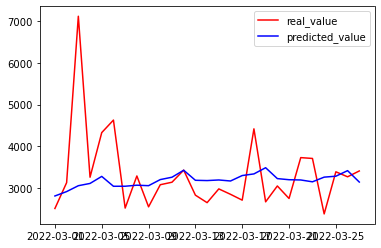

In [9]:
# draw
plt.plot(forecast['ds'], y_true[-27:]['備轉容量(萬瓩)'].tolist(), color='red', label='real_value')
plt.plot(forecast['ds'],forecast['yhat'].tolist(), color='blue', label='predicted_value')
plt.legend()
plt.show()